In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import normflows as nf
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm
import random
from torch.utils.data import DataLoader
import pandas as pd
import openturns as ot
print(f"Using device: {device}")
import pyvinecopulib as pv
from scipy.stats import gaussian_kde
from scipy.stats import gamma
from scipy.stats import expon
from scipy.stats import norm
from GPDFlow import DataTransform
from GPDFlow import T_mGPD_NF

/home/pgrad2/2448355h/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Using device: cuda


In [2]:
dir_out = "/home/pgrad2/2448355h/My_PhD_Project/01_Output/GPDFlow/"

dim = 10
base = nf.distributions.DiagGaussian(dim)
# base = my_DiagGaussian(dim)

num_layers = 16
torch.manual_seed(0)

latent_size = dim
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(num_layers):
    s = nf.nets.MLP([latent_size, 2 * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    t = nf.nets.MLP([latent_size, 2 * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]


f_T_model = nf.NormalizingFlow(base, flows)
f_T_model = f_T_model.to(device)

batch_size = 128
loss_history = []
epochs = 50

model = T_mGPD_NF(dim=dim, flow =f_T_model, device=device, s_min=-10,
                  s_max = 10, num_integration_points=1000, penalty_lambda=10000)

optimizer = torch.optim.Adam([
    {'params': model.flow_model.parameters(), 'lr': 1e-2},  # Flow layers
    {'params': model.data_transform.log_sigma, 'lr': 1e-1},  # Faster for log_sigma
    {'params': model.data_transform.theta, 'lr': 1e-1}       # Faster for gamma
], weight_decay = 1e-5 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

In [3]:
def sim_revexp_u_mgpd(n, d, a, beta, sig, gamma, MGPD=True, std=False):
    lam = np.exp(beta)
    Y = np.zeros((n, d))
    C = 1 / np.min(lam)
    k = 0

    while k < n:
        U = np.random.uniform(0, 1, d)
        W = (U ** a) / lam
        R = np.random.uniform(0, C)
        
        Ind = R < np.max(W)
        
        if Ind:
            Y[k, :] = W / R
            k += 1

    if std and not MGPD:
        return np.log(Y)

    X = []
    for j in range(d):
        if gamma[j] != 0:
            X.append(sig[j] * (Y[:, j] ** gamma[j] - 1) / gamma[j])
        else:
            X.append(sig[j] * np.log(Y[:, j]))
    X = np.column_stack(X)

    if MGPD and not std:
        return X
    if std and MGPD:
        return {'X': X, 'Z': np.log(Y)}

In [4]:
n_samples = 1000
n_experiments = 100
seed = 1234
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

for i in range(n_experiments):
    
    d = 10
    a = np.array([3,0.5,1, 5,2,  3,0.5,1, 5,2 ])
    beta = np.array([0, 0,0,0,0,  0, 0,0,0,0])
    sig = np.array([0.3,3,0.1,0.2,1.5,  0.3,3,0.1,0.2,1.5])
    gamma = np.array([-0.1, 0.2, 0, -0.05, 0.1,  -0.1, 0.2, 0, -0.05, 0.1])

    samples = sim_revexp_u_mgpd(n_samples, d, a, beta, sig, gamma)

    data = torch.tensor(samples, dtype=torch.float, device = device)

    memory = torch.cuda.memory_allocated(device) /10**9

    Training_Data = DataLoader(data, batch_size=batch_size, shuffle=True)
    torch.autograd.set_detect_anomaly(True)

    for epoch in range(epochs):
        epoch_loss = 0.0
        
        for x_data in Training_Data:
            # Sample a batch of data from h_U

            batch_loss = model(x_data)

            # Backpropagation
            optimizer.zero_grad()
            batch_loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            # Record loss
            loss_history.append(batch_loss.item())
            epoch_loss += batch_loss.item()

            if torch.isnan(batch_loss) or torch.isinf(batch_loss):
                print("NaN or Inf detected!")
                break

        # Debugging: Print shapes

        scheduler.step()
    torch.save(model.state_dict(), dir_out + f'model_10D_1000_{i}.pt')
    print(f"Completed Experiment {i} \n")



Completed Experiment 0 

Completed Experiment 1 

Completed Experiment 2 

Completed Experiment 3 

Completed Experiment 4 

Completed Experiment 5 

Completed Experiment 6 

Completed Experiment 7 

Completed Experiment 8 

Completed Experiment 9 

Completed Experiment 10 

Completed Experiment 11 

Completed Experiment 12 

Completed Experiment 13 

Completed Experiment 14 

Completed Experiment 15 

Completed Experiment 16 

Completed Experiment 17 

Completed Experiment 18 

Completed Experiment 19 

Completed Experiment 20 

Completed Experiment 21 

Completed Experiment 22 

Completed Experiment 23 

Completed Experiment 24 

Completed Experiment 25 

Completed Experiment 26 

Completed Experiment 27 

Completed Experiment 28 

Completed Experiment 29 

Completed Experiment 30 

Completed Experiment 31 

Completed Experiment 32 

Completed Experiment 33 

Completed Experiment 34 

Completed Experiment 35 

Completed Experiment 36 

Completed Experiment 37 

Completed Experiment 3

In [5]:
def chi_theorical(alpha1, alpha2):
    if alpha1 <= 0 or alpha2 <= 0:
        raise ValueError("alpha1 and alpha2 must be greater than 0")
    
    # Identify alpha_(1) = max(alpha1, alpha2) and alpha_(2) = min(alpha1, alpha2)
    alpha_max = max(alpha1, alpha2)
    alpha_min = min(alpha1, alpha2)
    
    # Calculate the components of the formula
    term1 = (1 + 1 / alpha_max) / (1 + 1 / alpha_min)
    term1_power = term1 ** (1 + alpha_min)
    term2 = (alpha_max / alpha_min) * (1 / (1 + alpha1 + alpha2))
    
    # Final chi value
    chi = 1 - term1_power * term2
    return chi

def pairwise_chi_theorical(alpha_vector):
    n = len(alpha_vector)
    chi_dict = {}
    
    for i in range(n-1):
        for j in range(i+1,n):
            chi_dict[f"{i+1}-{j+1}"] =  chi_theorical(alpha_vector[i], alpha_vector[j])
    
    return chi_dict

In [6]:
chi_values_theorical = pairwise_chi_theorical(1/a)
chi_values_theorical


{'1-2': np.float64(0.5132407700212496),
 '1-3': np.float64(0.4897639475816501),
 '1-4': np.float64(0.3318058612451248),
 '1-5': np.float64(0.4424743635628662),
 '1-6': np.float64(0.3999999999999999),
 '1-7': np.float64(0.5132407700212496),
 '1-8': np.float64(0.4897639475816501),
 '1-9': np.float64(0.3318058612451248),
 '1-10': np.float64(0.4424743635628662),
 '2-3': np.float64(0.71875),
 '2-4': np.float64(0.40792321620687566),
 '2-5': np.float64(0.5959389821791157),
 '2-6': np.float64(0.5132407700212497),
 '2-7': np.float64(0.8),
 '2-8': np.float64(0.71875),
 '2-9': np.float64(0.40792321620687566),
 '2-10': np.float64(0.5959389821791157),
 '3-4': np.float64(0.39186245321194657),
 '3-5': np.float64(0.5645351568385462),
 '3-6': np.float64(0.4897639475816502),
 '3-7': np.float64(0.71875),
 '3-8': np.float64(0.6666666666666667),
 '3-9': np.float64(0.39186245321194657),
 '3-10': np.float64(0.5645351568385462),
 '4-5': np.float64(0.3598892916940263),
 '4-6': np.float64(0.3318058612451248),
 

In [11]:
def empirical_upper_tail_dependence(X, p):

    # Compute the quantiles
    quantile = np.quantile(X, p, axis = 0)
    
    # Count joint exceedances
    joint_exceedance = np.sum((X[:,0] > quantile[0]) & (X[:,1] > quantile[1]))
    exceedance_X1 = np.sum(X[:,0] > quantile[0])
    
    # Calculate lambda_u
    if exceedance_X1 == 0:  # Avoid division by zero
        return 0.0
    chi_u = joint_exceedance / exceedance_X1
    return chi_u


def pairwise_chi_empirical(dim, model, n_monte_carlo, n_experiments):
    probs = np.linspace(0.80, 0.996, 100)
    # Compute lambda_u for each quantile
    sample_chi = {}
    for i in range(dim-1):
        for j in range(i+1,dim):
            chi_values = []
            for _ in range(n_experiments):  # Step 3: Repeat 200 times
                model.load_state_dict(torch.load(dir_out + f'model_5D_500_{_}.pt', weights_only=True))
                model.eval()
                samples_obs, samples_std, samples_T= model.sample(n_monte_carlo)
                sampled_data = samples_obs.cpu().data.numpy()
                chi_values.append(empirical_upper_tail_dependence(sampled_data[:,[i,j]], 0.99))
            sample_chi[f"{i+1}-{j+1}"] =  chi_values
    
    return sample_chi

In [12]:
chi_values_empipical = pairwise_chi_empirical(dim=5, model=model,  n_monte_carlo=10000, n_experiments=100)

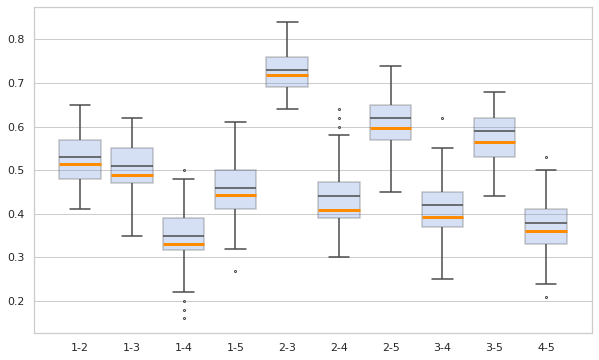

In [13]:
df = pd.DataFrame(chi_values_empipical)

# Create the boxplot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, color="cornflowerblue", fliersize=2, linewidth=1.5, boxprops=dict(alpha=0.3))
# ax.xaxis.grid(True)  # Enable vertical gridlines
# ax.yaxis.grid(True) 
for i, pair_index in enumerate(chi_values_theorical):
    plt.hlines(y=chi_values_theorical[pair_index], xmin=i - 0.4, xmax=i + 0.4, color='darkorange', linewidth=3)

In [10]:
sigma_dict = {f'sigma_{i}': [] for i in range(dim)}
gamma_dict = {f'gamma_{i}': [] for i in range(dim)}

for _ in range(n_experiments):  # Step 3: Repeat 200 times
    model.load_state_dict(torch.load(dir_out + f'model_10D_1000_{_}.pt', weights_only=True))
    model.eval()
    sigma_hat = model.data_transform.get_sigma().cpu().data.numpy()
    gamma_hat = model.data_transform.get_gamma().cpu().data.numpy()
    for i in range(dim):
        sigma_dict[f'sigma_{i}'].append(np.log(sigma_hat[i]))
        gamma_dict[f'gamma_{i}'].append(gamma_hat[i])


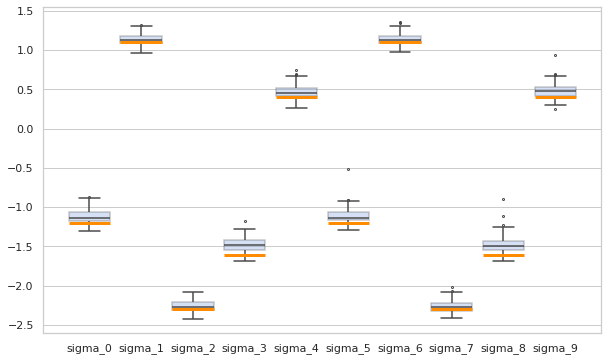

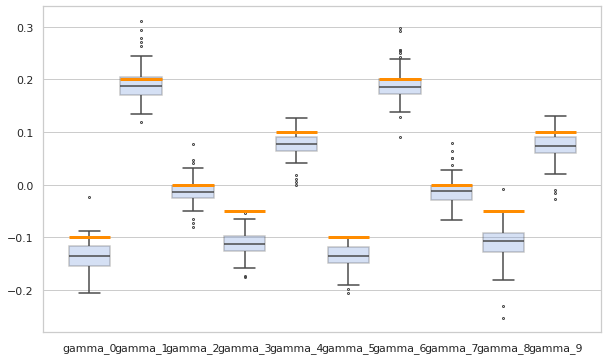

In [11]:
df_sigma = pd.DataFrame(sigma_dict)

# Create the boxplot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_sigma, color="cornflowerblue", fliersize=2, linewidth=1.5, boxprops=dict(alpha=0.3))
# ax.xaxis.grid(True)  # Enable vertical gridlines
# ax.yaxis.grid(True) 
for i in range(dim):
    plt.hlines(y=np.log(sig[i]), xmin=i - 0.4, xmax=i + 0.4, color='darkorange', linewidth=3)



df_gamma = pd.DataFrame(gamma_dict)

# Create the boxplot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_gamma, color="cornflowerblue", fliersize=2, linewidth=1.5, boxprops=dict(alpha=0.3))
# ax.xaxis.grid(True)  # Enable vertical gridlines
# ax.yaxis.grid(True) 
for i in range(dim):
    plt.hlines(y=gamma[i], xmin=i - 0.4, xmax=i + 0.4, color='darkorange', linewidth=3)